In [2]:
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
plt.rcParams.update({'font.size': 14})

from copy import deepcopy
import argparse
import os
import linsolve

from hera_cal import utils
from hera_cal import version
from hera_cal.noise import predict_noise_variance_from_autos
from hera_cal.datacontainer import DataContainer
from hera_cal.utils import split_pol, conj_pol, split_bl, reverse_bl, join_bl, join_pol, comply_pol
from hera_cal.io import HERAData, HERACal, write_cal, save_redcal_meta
from hera_cal.apply_cal import calibrate_in_place

## Importing functions
from hera_cal.redcal import _get_pol_load_list, filter_reds, redundantly_calibrate, expand_omni_sol,get_pos_reds ,add_pol_reds
import All_functions as logical ## Logi_Cal functions
import modified_redcal

### Fixing degenaracies


import hera_pspec as hp
import hera_cal as hc
from hera_sim import io

## Classification
from sklearn.cluster import KMeans

# import uvtools
# import hera_cal as hc
# import hera_pspec as hp
# from pyuvdata import UVCal, UVData
# import pyuvdata.utils as uvutils




SEC_PER_DAY = 86400.
IDEALIZED_BL_TOL = 1e-8  # bl_error_tol for redcal.get_reds when using antenna positions calculated from reds


In [3]:
# filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.calfits"## Gain file


##########################################################################################################################
##########################################################################################################################


# calib_param = "10_10_60"  ## Array_nfreq_ntimes

non_red_cases_list = ["case3a", "case_4a_0.01", "case_4b_0.01", "case_5"]
non_red_case = non_red_cases_list[0]

calib_param = "10_120_10"  ## Array_nfreq_ntimes

## ========================================================= Case 3a =================================================================
filename = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01_g_cal.uvh5"  ## Calibrated Data
filename1 = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01_g.uvh5"     ## Uncalibrated data
filename2 = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01.uvh5"       ## True data
gain_filename = "../non-redundant-pipeline/test_simulations/case_3a/calibration_" +calib_param+ "/viscatBC_stretch0.01.calfits"## Gain file

# ## ========================================================= Case 4a_0.01 =========================================================
# filename = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/test_simulations/case_4a_0.01/calibration_" +calib_param+ "/viscatBC_4a_0.01.calfits"## Gain file


# ## ========================================================= Case 4b_0.01 =========================================================
# filename = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/test_simulations/case_4b_0.01/calibration_" +calib_param+ "/viscatBC_4b_0.01.calfits"## Gain file


# ## ========================================================= Case 5 =========================================================
# filename = "../non-redundant-pipeline/test_simulations/case_5/calibration_" +calib_param+ "/viscatBC_5_g_cal.uvh5"  ## Calibrated Data
# filename1 = "../non-redundant-pipeline/test_simulations/case_5//calibration_" +calib_param+ "/viscatBC_5_g.uvh5"     ## Uncalibrated data
# filename2 = "../non-redundant-pipeline/test_simulations/case_5/calibration_" +calib_param+ "/viscatBC_5.uvh5"       ## True data
# gain_filename = "../non-redundant-pipeline/test_simulations/case_5/calibration_" +calib_param+ "/viscatBC_5.calfits"## Gain file


#############################################################################################################################################

# filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g_cal.uvh5"
# filename1 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.uvh5"
# gain_filename = "../non-redundant-pipeline/calibration_3a_0.01_10_10/viscatBC_stretch0.01.calfits"## Gain file


# filename = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01_g_cal.uvh5"
# filename1 = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01_g.uvh5"
# filename2 = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01.uvh5"
# gain_filename = "../non-redundant-pipeline/calibration/viscatBC_stretch0.01.calfits"  ## Gain file




c_data = HERAData(filename)   ## calibrated data
c_data.read()

hd = HERAData(filename1)   ## Uncalibrated data (data has noise and gains)
hd.read()

true_data = HERAData(filename2)  ## True data (No noise and gains)
true_data.read()


import utils

true_gains, _= hc.io.load_cal(gain_filename)  ## Calling dictionary of true gains

from hera_cal import utils


Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.
Telescope hera_sim is not in known_telescopes.


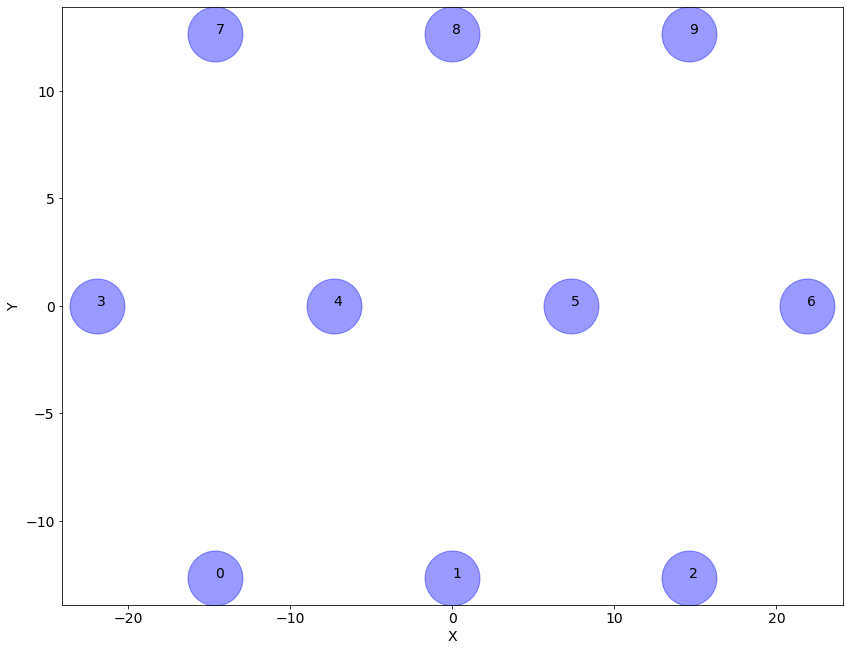

In [4]:
plt.figure(figsize=(14,11))

for i in range(len(hd.antpos)):
    plt.plot(hd.antpos[i][0], hd.antpos[i][1],'bo', alpha=0.4, label='0', markersize=55)
    plt.annotate("{}".format(i), (hd.antpos[i][0],hd.antpos[i][1] ))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Running Red_Cal

In [6]:
from hera_cal.redcal import redcal_iteration

# Running RedCal
red_gains = redcal_iteration(hd)

## Fixing degeneracies

red_gains_fixed = logical.fix_redcal_degeneracies(filename1, red_gains['g_omnical'],true_gains)

## Using modified_redcal.py to call Logi_cal

In [7]:
#### Using a k-means clustering

N_red_clusters = 4
k_value = 3
#Running Logi_Cal 

customized_groups = modified_redcal.get_custom_reds(hd,c_data,k_value,N_red_clusters)
custom_red_gains = modified_redcal.redcal_iteration_custom2(hd,customized_groups)


## Fixing degeneracies

custom_red_gains_fixed = logical.fix_redcal_degeneracies(filename1, custom_red_gains['g_omnical'], true_gains)



[[(0, 3, 'ee'), (2, 5, 'ee'), (6, 9, 'ee')], [(1, 4, 'ee'), (5, 8, 'ee')], [(4, 7, 'ee')], [(0, 4, 'ee')], [(1, 5, 'ee'), (5, 9, 'ee')], [(2, 6, 'ee'), (3, 7, 'ee'), (4, 8, 'ee')], [(0, 1, 'ee'), (4, 5, 'ee')], [(1, 2, 'ee'), (3, 4, 'ee'), (5, 6, 'ee'), (8, 9, 'ee')], [(7, 8, 'ee')], [(0, 7, 'ee')], [(1, 8, 'ee')], [(2, 9, 'ee')], [(1, 3, 'ee'), (2, 4, 'ee'), (5, 7, 'ee'), (6, 8, 'ee')], [(0, 5, 'ee'), (1, 6, 'ee'), (3, 8, 'ee'), (4, 9, 'ee')], [(0, 2, 'ee'), (3, 5, 'ee'), (4, 6, 'ee'), (7, 9, 'ee')], [(1, 7, 'ee'), (2, 8, 'ee')], [(0, 8, 'ee'), (1, 9, 'ee')], [(2, 3, 'ee'), (6, 7, 'ee')], [(0, 6, 'ee'), (3, 9, 'ee')], [(2, 7, 'ee')], [(0, 9, 'ee')], [(3, 6, 'ee')]]
redcal_iteration_custom2 Complete


Telescope hera_sim is not in known_telescopes.


## Using All_functions.py to call Logi_cal

In [23]:
#### Using a k-means clustering

N_red_clusters = 4
k_value = 3
#Running Logi_Cal 
customized_groups = logical.custom_reds2(hd,c_data,k_value,N_red_clusters)
custom_red_gains = logical.redcal_iteration_custom2(hd,customized_groups)


## Fixing degeneracies
custom_red_gains_fixed = logical.fix_redcal_degeneracies(filename1, custom_red_gains['g_omnical'], true_gains)



redcal_iteration_custom2 Complete


Telescope hera_sim is not in known_telescopes.


In [8]:
aa = [[(0, 3, 'ee'), (2, 5, 'ee'), (6, 9, 'ee')], [(1, 4, 'ee'), (5, 8, 'ee')], [(4, 7, 'ee')], [(0, 4, 'ee')], [(1, 5, 'ee'), (5, 9, 'ee')], [(2, 6, 'ee'), (3, 7, 'ee'), (4, 8, 'ee')], [(0, 1, 'ee'), (4, 5, 'ee')], [(1, 2, 'ee'), (3, 4, 'ee'), (5, 6, 'ee'), (8, 9, 'ee')], [(7, 8, 'ee')], [(0, 7, 'ee')], [(1, 8, 'ee')], [(2, 9, 'ee')], [(1, 3, 'ee'), (2, 4, 'ee'), (5, 7, 'ee'), (6, 8, 'ee')], [(0, 5, 'ee'), (1, 6, 'ee'), (3, 8, 'ee'), (4, 9, 'ee')], [(0, 2, 'ee'), (3, 5, 'ee'), (4, 6, 'ee'), (7, 9, 'ee')], [(1, 7, 'ee'), (2, 8, 'ee')], [(0, 8, 'ee'), (1, 9, 'ee')], [(2, 3, 'ee'), (6, 7, 'ee')], [(0, 6, 'ee'), (3, 9, 'ee')], [(2, 7, 'ee')], [(0, 9, 'ee')], [(3, 6, 'ee')]]